In [1]:
import numpy as np
from pydpmd.data import RigidBumpy, load
from pydpmd.plot import draw_particles_frame, create_animation, downsample
from correlation_functions import compute_msd, compute_shear_modulus, compute_rotational_msd, compute_pair_correlation_function
from pydpmd.calc import run_binned, fused_msd_kernel, TimeBins, LagBinsExact, LagBinsLog, LagBinsLinear, LagBinsPseudoLog, requires_fields
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
import re
from tqdm import tqdm

In [2]:
root = '/home/mmccraw/dev/data/09-27-25/run-1/'
R = re.compile(rf'^dynamics_(\d+)$')
ds = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root,d)) and R.fullmatch(d)]
run_names = [os.path.join(root,d) for d in sorted(ds,key=lambda s:int(R.fullmatch(s).group(1)))]

x = []
y = []
z = []
c = []
p = []
o = []

for run_name in run_names:
    try:
        data = load(run_name, location=['final', 'init'], load_trajectory=True, load_full=False)
        data.calculate_mu_eff()
    except:
        continue
    msd_path = os.path.join(run_name, 'msd.npz')
    msd, t = compute_rotational_msd(data, msd_path, overwrite=False)
    shear_modulus_path = os.path.join(run_name, 'shear_modulus.npz')
    shear_modulus, t = compute_shear_modulus(data, shear_modulus_path, overwrite=False, subtract_mean_stress=True)
    pair_correlation_function_path = os.path.join(run_name, 'pair_correlation_function.npz')
    radial_bins = np.linspace(0.5, 3, 1000)
    G, r = compute_pair_correlation_function(data, radial_bins, pair_correlation_function_path, overwrite=False)

    pressure = np.mean([data.trajectory[i].pressure for i in range(data.trajectory.num_frames())], axis=0)
    te = np.array([data.trajectory[i].pe_total + data.trajectory[i].ke_total for i in range(data.trajectory.num_frames())])
    te_fluc = np.std(te, axis=0) / np.mean(te, axis=0)
    phi = data.packing_fraction

    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=0, vmax=len(phi))
    mu_norm = LogNorm(vmin=min(data.mu_eff), vmax=max(data.mu_eff))

    # plt.scatter(data.mu_eff[data.system_offset[:-1]], r[np.argmax(G, axis=-1)][:, 0], c=cmap(norm(phi)))
    # plt.scatter(phi, r[np.argmax(G, axis=-1)][:, 0], c=cmap(mu_norm(data.mu_eff[data.system_offset[:-1]])))
    x.append(phi)
    y.append(r[np.argmax(G, axis=-1)][:, 0])
    z.append(data.n_vertices_per_particle[data.system_offset[:-1]])
    c.append(data.mu_eff[data.system_offset[:-1]])
    p.append(pressure)
    o.append(np.mean([data.trajectory[i].pe_total for i in range(data.trajectory.num_frames())], axis=0))

    if phi[24] > 0.81:
        break

    # plt.plot(r, G[1, 0])
    # plt.plot(r, G[21, 0])
    # if phi[1] > 0.75:
        # break

#     for i in range(len(phi)):
#         plt.scatter(phi[i], te_fluc[i], c=cmap(norm(i)))
# plt.yscale('log')

#     for i in range(len(phi)):
#         plt.scatter(phi[i], pressure[i], c=cmap(norm(i)))
# plt.yscale('log')

x = np.array(x)
y = np.array(y)
z = np.array(z)
c = np.array(c)
p = np.array(p)
o = np.array(o)

/tmp/ipykernel_521496/3543911582.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x[mask], p[mask], c=cmap(mu_norm(m)))


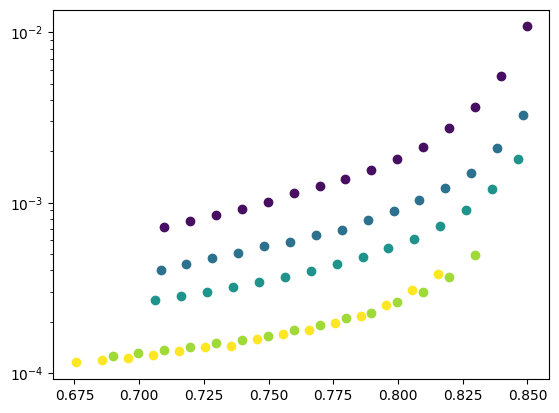

In [3]:
pc = 1e2
for n in np.unique(z):
    for m in np.unique(c):
        if np.any((z == n) & (c == m)):
            if n != 31:
                continue
            mask = (z == n) & (c == m) & (p < pc)
            # plt.scatter(x[mask], y[mask], c=cmap(mu_norm(m)))
            plt.scatter(x[mask], p[mask], c=cmap(mu_norm(m)))
plt.yscale('log')

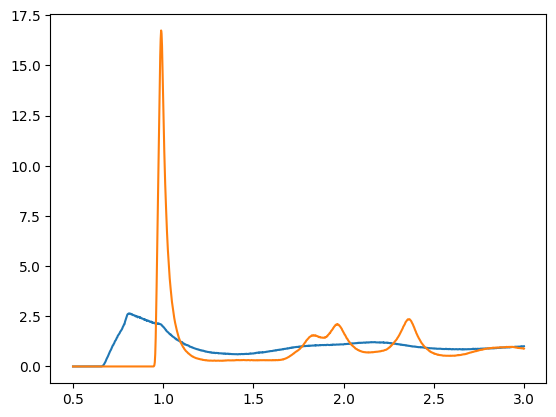

In [206]:
plt.plot(r, G[20, 0])
plt.plot(r, G[24, 0])

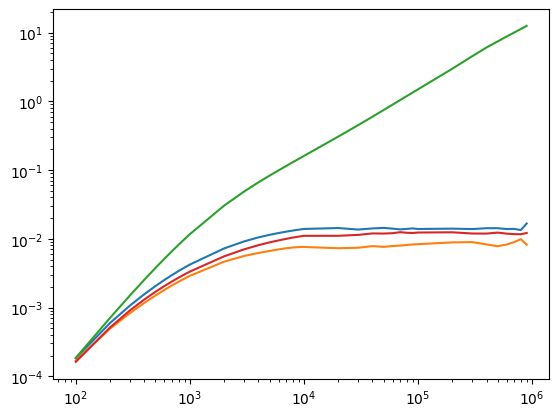

In [208]:
plt.plot(t, msd[:, 0, 0])
plt.plot(t, msd[:, 1, 0])
plt.plot(t, msd[:, 20, 0])
plt.plot(t, msd[:, 24, 0])
plt.xscale('log')
plt.yscale('log')

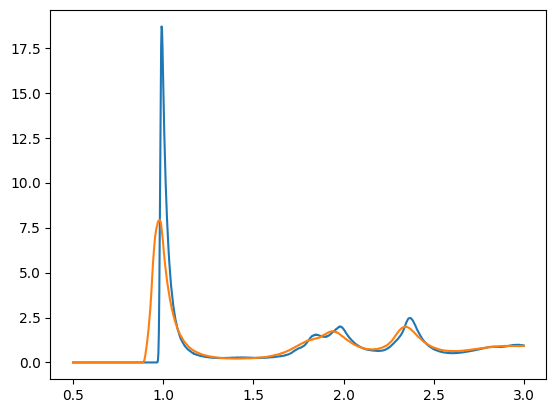

In [210]:
plt.plot(r, G[0, 0])
plt.plot(r, G[10, 0])

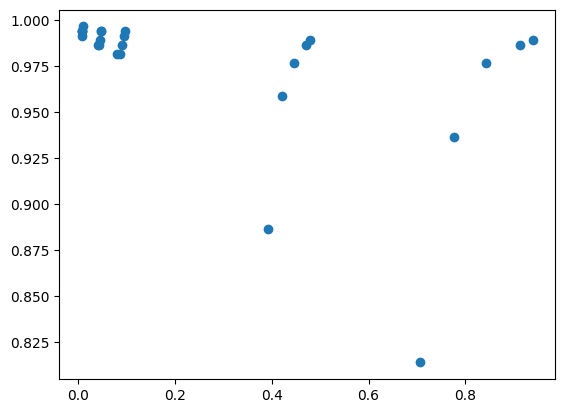

In [211]:
plt.scatter(data.mu_eff[data.system_offset[:-1]], r[np.argmax(G, axis=-1)][:, 0])


In [212]:
data.packing_fraction[24]

np.float64(0.8155302879366072)

(2.0, 5.0)

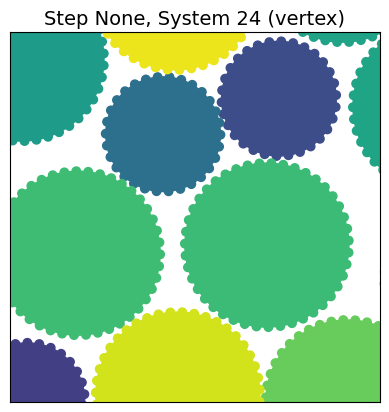

In [215]:
draw_particles_frame(None, plt.gca(), data, 24, True, 'vertex', 'viridis', None)
plt.xlim(2, 5)
plt.ylim(2, 5)

# Solving for temperature where the smallest vertices are only overlapped by 10% gives T=10^-7


# Should probably check other temperatures!

# TODO:

- Queue up runs on bouchet?

- Analyze msd and pair correlations

- Get an answer on the G(t)

- Friction

- Contacts

In [6]:
(1e-2 * data.vertex_rad[data.vertex_system_offset[:-1]].min()) ** 2 / 1e-5

np.float64(0.01184243797237905)

In [22]:
root = "/home/mmccraw/dev/data/09-27-25/run-3/"
data = load(os.path.join(root, "dynamics_1"), location=["final", "init"], load_trajectory=True, load_full=True)

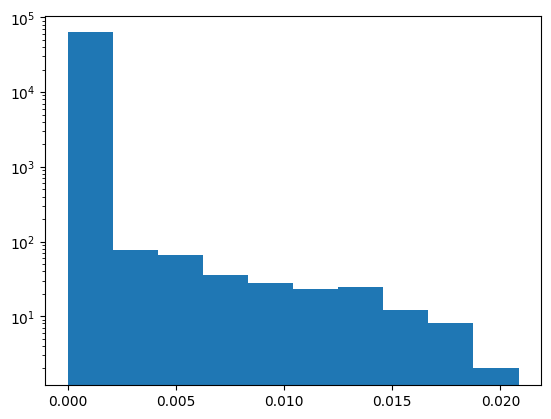

In [43]:
data.trajectory.overlaps.shape

overlaps = data.trajectory.overlaps.copy()
mask = overlaps[:, :, 1] > 0
overlaps[mask, 0] = overlaps[mask, 0] / overlaps[mask, 1]
plt.hist(overlaps[:, :, 0].flatten())
plt.yscale('log')

In [18]:
desired_frames = 100
steps_to_animate = downsample(data, desired_frames)

# Define the output path
output_path = "test.gif"

# Create the animation using the downsampled steps
create_animation(
    update_func=draw_particles_frame,
    frames=steps_to_animate,
    filename=output_path,
    fps=15,  # 15 fps for smooth but not too fast animation
    dpi=150,  # Higher resolution
    bitrate=3000,  # Higher bitrate for better quality
    # Keyword arguments passed to draw_particles_frame
    data=data,
    system_id=1,
    use_pbc=True,
    which='vertex',
    cmap_name='viridis'
)

Creating animation:   3%|▎         | 3/100 [00:00<00:04, 20.82it/s]

Saving animation to test.gif...


Creating animation: 101it [00:10,  9.42it/s]                         

Animation saved successfully!
